In [45]:
import s3fs
import boto3

import pandas as pd
import geopandas as gpd

import requests
from requests.auth import HTTPBasicAuth

from multiprocessing import Pool
from functools import partial

import tqdm
import numpy as np

from os import path
import json

from shapely.geometry import Polygon, shape

from retrying import retry

from IPython.display import Markdown

import cartopy.feature as cfeatures
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

%matplotlib inline


# Planet Archive Catalog

The S3 bucket `planet-snowcover-archive` (in the `us-west-2` region) has ~800GB of imagery data within it. We need to catalog the metadata of these images. 

In [6]:
fs = s3fs.S3FileSystem(session=boto3.Session(profile_name='esip'))

In [7]:
archive = fs.ls('planet-snowcover-archive')

In [8]:
archive[:5]

['planet-snowcover-archive/PSScene4Band_20170125_175925_0e20_all_udm2.zip',
 'planet-snowcover-archive/PSScene4Band_20170125_175926_0e20_all_udm2.zip',
 'planet-snowcover-archive/PSScene4Band_20170125_175927_0e20_all_udm2.zip',
 'planet-snowcover-archive/PSScene4Band_20170125_175928_0e20_all_udm2.zip',
 'planet-snowcover-archive/PSScene4Band_20170125_175929_0e20_all_udm2.zip']

In [9]:
Markdown("**# Images In Catalog**: {}".format(len(archive)))

**# Images In Catalog**: 22534

## Use Planet API to access metadata

We'll use the `/v1/item-types/{}/items{}` endpoint. **Requires `~/.planet.json` file**

In [28]:
@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_metadata(imgdata, api_key):
    PLANET_API = "https://api.planet.com/data/v1/item-types/{item_type_id}/items/{item_id}"
    request_url = PLANET_API.format(item_type_id = imgdata[0], item_id = imgdata[1])
    _r = requests.get(request_url, 
                      auth = HTTPBasicAuth(api_key, ''))
    
    if not _r.status_code in [200, 404]: 
#         print("not ok status [{}] ({})".format(_r.status_code, _r.text))
        raise(Exception())
    
    return(_r.json())

## Convert filenames to Type/ID

In [10]:
imageTypes = [path.basename(p).split("_")[0] for p in archive]
imageTypes[:5]

['PSScene4Band',
 'PSScene4Band',
 'PSScene4Band',
 'PSScene4Band',
 'PSScene4Band']

In [11]:
imageIDs = ["_".join(path.basename(p).split("_")[1:4]) for p in archive]
imageIDs[:5]

['20170125_175925_0e20',
 '20170125_175926_0e20',
 '20170125_175927_0e20',
 '20170125_175928_0e20',
 '20170125_175929_0e20']

In [12]:
archiveParts = zip(archive, imageTypes, imageIDs)

## Test on small list

In [12]:
# pool = Pool(processes=5)

api_key = json.load(open(path.expanduser("~/.planet.json")))['key']
get_metadata_auth = partial(get_metadata, api_key=api_key)

In [15]:
metadataSmall = list(map(get_metadata_auth, zip(imageTypes[:5], imageIDs[:5])))

In [16]:
metadataSmall

[{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170125_175925_0e20',
   'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170125_175925_0e20/assets/',
   'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20170125_175925_0e20/thumb'},
  '_permissions': ['assets.udm:download',
   'assets.analytic:download',
   'assets.analytic_xml:download',
   'assets.analytic_dn:download',
   'assets.analytic_dn_xml:download',
   'assets.basic_analytic:download',
   'assets.basic_analytic_rpc:download',
   'assets.basic_analytic_dn:download',
   'assets.basic_analytic_dn_rpc:download',
   'assets.basic_analytic_xml:download',
   'assets.basic_analytic_dn_xml:download',
   'assets.basic_analytic_dn_nitf:download',
   'assets.basic_analytic_dn_rpc_nitf:download',
   'assets.basic_analytic_dn_xml_nitf:download',
   'assets.basic_analytic_nitf:download',
   'assets.basic_analytic_rpc_nitf:download',
   'assets.basic_an

## Run for entire dataset

In [29]:
metadata = list(map(get_metadata_auth, tqdm.tqdm(zip(imageTypes, imageIDs), total=len(archive))))

100%|██████████| 22534/22534 [1:08:28<00:00,  5.48it/s]


## Process Results
We'll first save them as raw data. Then remove the ones that 404'd and assess those more closely.

### Filter Raw Results

In [36]:
md_array = np.array(metadata)
np.savez_compressed("catalog", md_array)

In [22]:
md_array = np.load("catalog.npz").items()[0][1]

In [24]:
# Check for 404s (they don't have "_links")
mask_nan = np.array(['_links' in i for i in md_array])

In [25]:
missedIDs = np.array(imageIDs)[~mask_nan]

In [26]:
metadata_raw = md_array[mask_nan]

### Convert to GeoDataFrame

In [69]:
metaDF = pd.io.json.json_normalize(metadata_raw)

In [70]:
metaDF = metaDF.set_index('id')

In [71]:
metaGeoms = [shape({
    'type' : row['geometry.type'],
    'coordinates': row['geometry.coordinates']
}) for _, row in metaDF.iterrows()]

In [72]:
metaDF = metaDF.drop(['geometry.coordinates', 'geometry.type', '_permissions'], axis=1, )

In [73]:
metaGDF = gpd.GeoDataFrame(metaDF, geometry=metaGeoms)

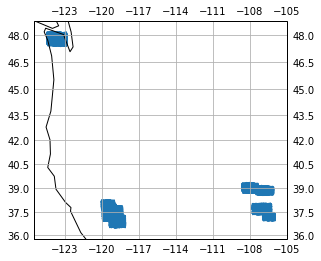

In [54]:
ax = plt.subplot(projection=ccrs.Mercator().GOOGLE)
metaGDF.plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeatures.COASTLINE)
ax.gridlines(draw_labels=True)

In [74]:
metaGDF.to_file("planet-archive-catalog.geojson", driver='GeoJSON')

In [75]:
!ls -lh

total 113576
-rw-r--r--@ 1 tony  staff   2.5M Oct  4 15:42 ASO_Planet_footprint.ipynb
-rw-r--r--@ 1 tony  staff    52K Jan 16 15:10 Untitled.ipynb
-rw-r--r--@ 1 tony  staff     0B Jan 10 08:46 archive_catalog.sh
-rw-r--r--@ 1 tony  staff    11M Jan 16 14:40 catalog.npz
-rw-r--r--@ 1 tony  staff    42M Jan 16 15:10 planet-archive-catalog.geojson


In [76]:
metaGDF.to_file("planet-archive-catalog.shp")

### Upload to S3 Bucket

In [86]:
fs.put("planet-archive-catalog.geojson", 'planet-snowcover-archive/planet-archive-catalog.geojson')